### 0. Import libraries and load data

In [13]:
import os
import sys
import json
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image

FOLDER_PATH = "../data/"
DATABASE_FILE_NAME = "database/database_lite.json"
QUERY_FILE_NAME = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [14]:
# map
with open(FOLDER_PATH + DATABASE_FILE_NAME,"r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

# query
with open(FOLDER_PATH + QUERY_FILE_NAME,"r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File(FOLDER_PATH + SIMILARITY_FILE_NAME,"r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

### 1. Pre-process images

In [15]:
def get_image_shapes(image_paths):
    image_shapes = set()

    for image_path in image_paths:
        img = plt.imread(os.path.join(FOLDER_PATH + image_path))
        image_shapes.add(img.shape)
    
    return image_shapes

In [16]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    smallest_image_shape = None
    smallest_image_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_image_size:
            smallest_image_size = image_size
            smallest_image_shape = img_shape

    return smallest_image_shape

In [17]:
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)
print(f"\nSmallest image shape is: {smallest_image_shape}")

Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape is: (256, 341, 3)


In [18]:
def load_images(image_paths, image_size):
    preprocessed_images = np.zeros((len(image_paths), image_size[0], image_size[1], image_size[2]))

    for index, image_path in enumerate(image_paths):
        raw_img = image.load_img(FOLDER_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype('float32')
        preprocessed_images[index] = array_img
    
    return preprocessed_images

In [19]:
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")

query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")

Shape of database dataset: (1000, 256, 341, 3)
Shape of query dataset: (500, 256, 341, 3)


In [20]:
def display_reshaped_image(database_images, m_imgs, image_index):
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(plt.imread(os.path.join(FOLDER_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()

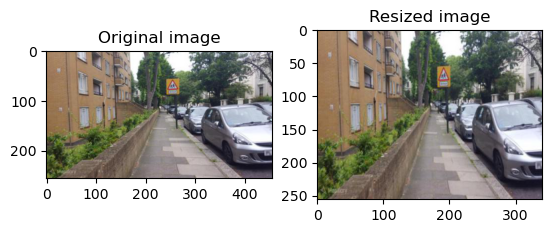

In [21]:
display_reshaped_image(database_images, m_imgs, image_index=6)